# Skin Cancer detection using a fine-tuned Xception model

> author: *dxmxnlord*

> dataset: [here](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/notebooks)

Combine both directories into one

In [27]:
!mkdir skin_images
!cp -r /content/HAM10000_images_part_1/* ./skin_images
!cp -r /content/HAM10000_images_part_2/* ./skin_images

Ensure the number of files match and all the files are of the same type

In [28]:
!echo $(ls skin_images | grep -Po "\.[^.]*$" | uniq -c)
!echo $(($(ls /content/HAM10000_images_part_1/ | wc -l) + $(ls /content/HAM10000_images_part_2/ | wc -l)))


  10015 .jpg


# Model 1
Classify the type of skin cancer found in a sample

In [22]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
data = pd.read_csv('HAM10000_metadata.csv')

Categorize the type of skin cancer from the dataset and store in an array. After that perform one hot encoding in order to make it compatible with a softmax layer.

In [91]:
lesions = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
cells = data['dx'].map(lesions.get)
cells = pd.Categorical(cells).codes
cells = np.asarray(cells).astype(np.float32)
cells = tf.keras.utils.to_categorical(cells)
cells

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

Get the paths of all the images

In [75]:
im_path = os.path.join(os.getcwd(),'skin_images')
images_path = data['image_id'].map(lambda im : str(os.path.join(im_path, im)+'.jpg'))
images_path

0        /content/skin_images/ISIC_0027419.jpg
1        /content/skin_images/ISIC_0025030.jpg
2        /content/skin_images/ISIC_0026769.jpg
3        /content/skin_images/ISIC_0025661.jpg
4        /content/skin_images/ISIC_0031633.jpg
                         ...                  
10010    /content/skin_images/ISIC_0033084.jpg
10011    /content/skin_images/ISIC_0033550.jpg
10012    /content/skin_images/ISIC_0033536.jpg
10013    /content/skin_images/ISIC_0032854.jpg
10014    /content/skin_images/ISIC_0032258.jpg
Name: image_id, Length: 10015, dtype: object

Load all the images into a numpy array. The images are resized to (71,71) since it is the input size for the Xception model used as the base model. The values are then normalized. Then they are split into training, testing, and validation sets.

In [87]:
import cv2
images = []
for image_path in images_path:
  img=cv2.imread(image_path)
  img=cv2.resize(img,(71,71))
  images.append(img)
images=np.array(images)/255.0
print(images.shape,cells.shape)

(10015, 71, 71, 3) (10015, 7, 2)


In [92]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(images,cells, test_size=0.20,random_state=42)
train_data, val_data, train_target, val_target = train_test_split(train_data,train_target, test_size=0.10,random_state=42)

Deep Learning model
+ We are using transfer learning by using a pre trained Xception model and fine tuning it by adding additional layers.
+ The base model is an Xception model whose layers have been unfrozen
+ 4 dense layers are added for fine tuning the base model on the data set
+ Each layer is accompanied by batch normalization, dropout and a relu activation function
+ The last layer is a softmax classification layer
+ Each dense layer uses *he uniform initialization* over glorot since it perform better on the Xception model - [Glorot vs He](https://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)


In [111]:
base = Xception(include_top = False , input_shape = (71,71,3))
for layer in base.layers:
    layer.trainable = True
layer = base.output
layer = Flatten()(layer)
# layer 1
layer = Dense(256, kernel_initializer='he_uniform')(layer)
layer = Dropout(0.5)(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
# layer 2
layer = Dense(128, kernel_initializer='he_uniform')(layer)
layer = Dropout(0.5)(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
# layer 3
layer = Dense(64, kernel_initializer='he_uniform')(layer)
layer = Dropout(0.5)(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
# layer 4
layer = Dense(16, kernel_initializer='he_uniform')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
# layer 5
layer = Dense(7,activation='softmax')(layer)
model = Model(inputs=base.input, outputs=layer)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

The model is trained over 30 epochs with a mini batch size of 64 units and is set up for an early stopping over 3 epochs.

In [112]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model_callbacks = [EarlyStopping(patience=3)]

In [113]:
history = model.fit(train_data,train_target,epochs=30,callbacks=model_callbacks,validation_data=(val_data,val_target),batch_size=64)

Epoch 1/30
113/113 [==============================] - 967s 9s/step - loss: 1.7605 - accuracy: 0.4842 - val_loss: 1.4467 - val_accuracy: 0.6708
Epoch 2/30
113/113 [==============================] - 984s 9s/step - loss: 1.0784 - accuracy: 0.6756 - val_loss: 1.0480 - val_accuracy: 0.6895
Epoch 3/30
113/113 [==============================] - 1005s 9s/step - loss: 0.8973 - accuracy: 0.7010 - val_loss: 0.8634 - val_accuracy: 0.7319
Epoch 4/30
113/113 [==============================] - 995s 9s/step - loss: 0.8162 - accuracy: 0.7214 - val_loss: 0.8695 - val_accuracy: 0.7419
Epoch 5/30
113/113 [==============================] - 984s 9s/step - loss: 0.7649 - accuracy: 0.7337 - val_loss: 0.8034 - val_accuracy: 0.7294
Epoch 6/30
113/113 [==============================] - 942s 8s/step - loss: 0.6882 - accuracy: 0.7584 - val_loss: 0.7386 - val_accuracy: 0.7581
Epoch 7/30
113/113 [==============================] - 935s 8s/step - loss: 0.6317 - accuracy: 0.7817 - val_loss: 0.7635 - val_accuracy: 0.749

Some Statistics

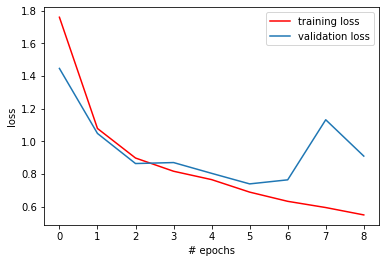

In [115]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

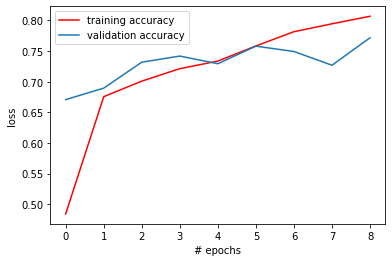

In [116]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [114]:
print(model.evaluate(test_data,test_target))

63/63 [==============================] - 48s 767ms/step - loss: 0.8842 - accuracy: 0.7569
[0.8841530680656433, 0.7568647265434265]
